# Deep Learning: Sentiment Analysis

- Let's get back to the Senitment Analysis on the NLTK Movie Reviews datasets 

![](../images/keras-workflow.png)

## Prepare Data

In [1]:
import numpy as np
import nltk
from nltk.corpus import movie_reviews
import random

In [2]:
documents = [(' '.join(list(movie_reviews.words(fileid))), category)
             for category in movie_reviews.categories()
             for fileid in movie_reviews.fileids(category)]

documents = [(text,1) if label=="pos" else (text, 0) for (text, label) in documents]

random.shuffle(documents)

In [3]:
documents[1]

("metro i ' ve seen san francisco in movies many times . there was 1994 ' s interview with the vampire and most recently the rock . now , yet again , san francisco is the setting for this movie . eddie murphy stars as inspector scott roper of the sfpd . he is their top hostage negotiator , and the very best at what he does . when his best friend on the force is killed by joe ( michael wincott , in a terrific performance ) , a psychotic , demented jewel thief , roger makes it his mission to capture the guy before he strikes again . meanwhile , roper tries to rekindle a relationship with his british ex - girlfriend veronica , while helping to rear a new up and comer from swat who ' s an expert sniper and marksman ( michael rappaport ) . despite the obligatory cop movie scenes ( does every cop / new partner movie have to start the same way ? ) where the sgt . assigns roper a partner , roper confronts the sarge , etc . , this film is still one heck of an explosive ride . a scene involving 

## Train-Test Split

In [4]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(documents, test_size = 0.1, random_state=42)
print(len(train_set), len(test_set))

1800 200


## Prepare Input and Output Tensors

- In deep learning, words or characters are automatically converted into numeric representations.
- In other words, the feature engineering step is fully automatic.

- Steps:
    - Text to Integers
    - Padding each instance to be of same lengths
    

In [5]:
import tensorflow as tf
import tensorflow.keras as keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical, plot_model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import SpatialDropout1D
from keras.layers import Bidirectional

In [6]:
texts = [n for (n, l) in train_set]
labels = [l for (n, l) in train_set] 

In [7]:
print(len(texts))
print(len(labels))

1800
1800


### Tokenizer

- By default, the token index 0 is reserved for padding token.
- If `oov_token` is specified, it is default to index 1.
- Specify `num_words` for tokenizer to include only top N words in the model
- Tokenizer will automatically remove puntuations.
- Tokenizer use whitespace as word delimiter.
- If every character is treated as a token, specify `char_level=True`.

In [8]:
NUM_WORDS = 10000
tokenizer = Tokenizer(num_words = NUM_WORDS)
tokenizer.fit_on_texts(texts)

### Vocabulary

- When computing the vocabulary size, the plus 1 is due to the addition of the padding token.
- if `oov_token` is specified, then the vocabulary size needs to be added one more.

In [9]:
# determine the vocabulary size
# vocab_size = len(tokenizer.word_index) + 1
vocab_size = tokenizer.num_words + 1
print('Vocabulary Size: %d' % vocab_size)


Vocabulary Size: 10001


In [10]:
list(tokenizer.word_index.items())[:20]

[('the', 1),
 ('a', 2),
 ('and', 3),
 ('of', 4),
 ('to', 5),
 ("'", 6),
 ('is', 7),
 ('in', 8),
 ('s', 9),
 ('it', 10),
 ('that', 11),
 ('as', 12),
 ('with', 13),
 ('for', 14),
 ('this', 15),
 ('his', 16),
 ('film', 17),
 ('i', 18),
 ('he', 19),
 ('but', 20)]

In [11]:
len(tokenizer.word_index)

37959

## Define X and Y (Text Vectorization)

### From Texts and Tensors

- There are two main ways of text vectorization:
    - Texts to Matrix: **One-hot encoding** of texts (similar to bag-of-words model)
    - Texts to Sequences: **Integer encoding** of all word tokens in texts and we will learn token **embeddings** along with the networks
    

### Method 1: Text to Sequences

- Text to sequences (integers)
- Pad sequences

#### Text to Sequences

In [12]:
texts_ints = tokenizer.texts_to_sequences(texts)

#### Padding

:::{tip}
When dealing with texts and documents, padding each text to the maximum length may not be ideal. For example, for sentiment classification, it is usually the case that authors would highlight more his/her sentiment at the end of the text. Therefore, we can specify an arbitrary `max_len` in padding the sequences to (a) reduce the risk of including too much noise in our model, and (b) speed up the training steps.
:::

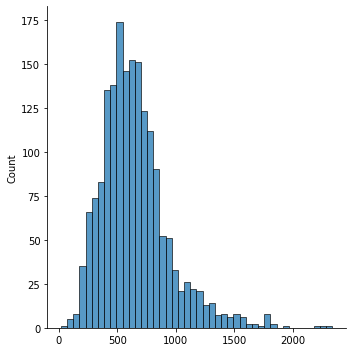

In [13]:
texts_lens=[len(n) for n in texts_ints]
texts_lens
import seaborn as sns
sns.displot(texts_lens)

In [14]:
max_len = texts_lens[np.argmax(texts_lens)]
max_len

2334

- In this tutorial, we consider only the **final** 400 tokens of each text.
- `padding` and `truncating` parameters in `pad_sequences`: whether to Pre-padding or removing values from the beginning of the sequence (i.e., `pre`) or the other way (`post`).

In [15]:
max_len = 400

In [16]:
texts_ints_pad = sequence.pad_sequences(texts_ints, maxlen = max_len, truncating='pre', padding='pre')
texts_ints_pad[:10]

array([[  26,    4,    1, ...,    1,  451,  481],
       [1130,   50, 3112, ...,   30,  253,  188],
       [5764,   36,    1, ...,   51,   83, 1209],
       ...,
       [ 276,  216,   82, ...,  559,    4, 4150],
       [   0,    0,    0, ...,    2,  177,   64],
       [2689, 3434, 1677, ...,  396, 1119,   15]], dtype=int32)

In [17]:
X_train = np.array(texts_ints_pad).astype('int32')
y_train = np.array(labels)

X_test_texts = [n for (n, l) in test_set]
X_test = np.array(
    sequence.pad_sequences(tokenizer.texts_to_sequences(X_test_texts),
                           maxlen=max_len,
                           padding='pre',
                           truncating='pre')).astype('int32')
y_test = np.array([l for (n, l) in test_set])

In [18]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1800, 400)
(1800,)
(200, 400)
(200,)


### Method 2: Text to Matrix (One-hot Encoding/Bag-of-Words)

In [19]:
texts_matrix = tokenizer.texts_to_matrix(texts, mode="binary")

In [20]:
X_train2 = np.array(texts_matrix).astype('int32')
y_train2 = np.array(labels)

X_test2 = tokenizer.texts_to_matrix(X_test_texts, mode="binary").astype('int32')
y_test2 = np.array([l for (n,l) in test_set])

In [21]:
print(X_train2.shape)
print(y_train2.shape)
print(X_test2.shape)
print(y_test2.shape)

(1800, 10000)
(1800,)
(200, 10000)
(200,)


## Model Definition

In [22]:
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd

matplotlib.rcParams['figure.dpi'] = 150

# Plotting results
def plot(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc)+1)
    ## Accuracy plot
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    ## Loss plot
    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

    
def plot2(history):
    pd.DataFrame(history.history).plot(figsize=(8,5))
    plt.grid(True)
    #plt.gca().set_ylim(0,1)
    plt.show()

### Model 1

- Two layers of fully-connected dense layers
- The input is the one-hot encoding of the text from text-to-matrix.

![](../images/movie-review-classifier-dl/movie-review-classifier-dl.002.jpeg)

In [23]:
from keras import layers
model1 = keras.Sequential()
model1.add(keras.Input(shape=(NUM_WORDS,)))
model1.add(layers.Dense(16, activation="relu", name="dense_layer_1"))
model1.add(layers.Dense(16, activation="relu", name="dense_layer_2"))
model1.add(layers.Dense(1, activation="sigmoid", name="output"))

model1.compile(
    loss=keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(lr=0.001),
    metrics=["accuracy"]
)


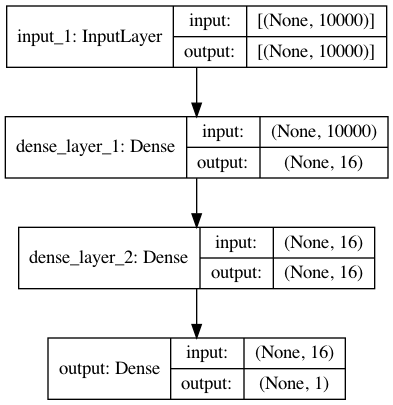

In [24]:
plot_model(model1, show_shapes=True)

In [25]:
## A few DL hyperparameters
BATCH_SIZE = 128
EPOCHS = 25
VALIDATION_SPLIT = 0.2

In [26]:
history1 = model1.fit(X_train2, y_train2, 
                    batch_size=BATCH_SIZE, 
                    epochs=EPOCHS, verbose=2,
                   validation_split = VALIDATION_SPLIT)

Epoch 1/25
12/12 - 4s - loss: 0.6592 - accuracy: 0.6118 - val_loss: 0.5941 - val_accuracy: 0.7528
Epoch 2/25
12/12 - 0s - loss: 0.4200 - accuracy: 0.9090 - val_loss: 0.4539 - val_accuracy: 0.8194
Epoch 3/25
12/12 - 0s - loss: 0.2277 - accuracy: 0.9556 - val_loss: 0.4024 - val_accuracy: 0.8278
Epoch 4/25
12/12 - 0s - loss: 0.1177 - accuracy: 0.9896 - val_loss: 0.3573 - val_accuracy: 0.8500
Epoch 5/25
12/12 - 0s - loss: 0.0620 - accuracy: 1.0000 - val_loss: 0.3451 - val_accuracy: 0.8444
Epoch 6/25
12/12 - 0s - loss: 0.0358 - accuracy: 1.0000 - val_loss: 0.3408 - val_accuracy: 0.8583
Epoch 7/25
12/12 - 0s - loss: 0.0231 - accuracy: 1.0000 - val_loss: 0.3390 - val_accuracy: 0.8444
Epoch 8/25
12/12 - 0s - loss: 0.0162 - accuracy: 1.0000 - val_loss: 0.3409 - val_accuracy: 0.8444
Epoch 9/25
12/12 - 0s - loss: 0.0119 - accuracy: 1.0000 - val_loss: 0.3442 - val_accuracy: 0.8528
Epoch 10/25
12/12 - 0s - loss: 0.0092 - accuracy: 1.0000 - val_loss: 0.3460 - val_accuracy: 0.8500
Epoch 11/25
12/12 -

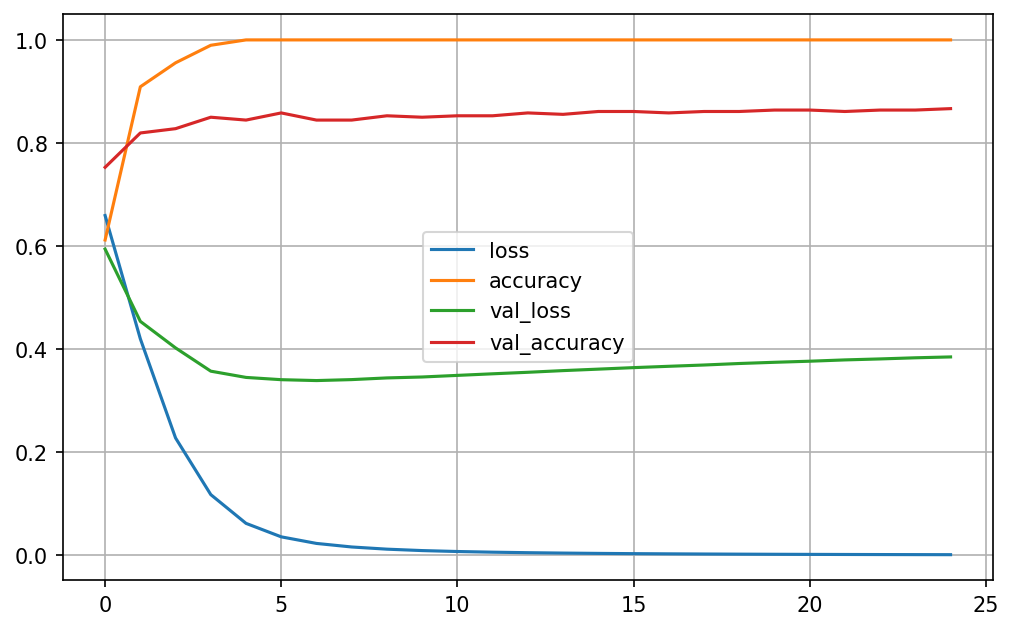

In [27]:
plot2(history1)

In [28]:
model1.evaluate(X_test2, y_test2, batch_size=BATCH_SIZE, verbose=2)

2/2 - 0s - loss: 0.3692 - accuracy: 0.8700


[0.3691900670528412, 0.8700000047683716]

### Model 2

- One Embedding Layer + Two layers of fully-connected dense layers
- The Input is the integer encodings of texts from the padded text-to-sequence.

![](../images/movie-review-classifier-dl/movie-review-classifier-dl.004.jpeg)

![](../images/movie-review-classifier-dl/movie-review-classifier-dl.008.jpeg)

In [29]:
EMBEDDING_DIM = 128
model2 = Sequential()
model2.add(
    Embedding(input_dim=vocab_size,
              output_dim=EMBEDDING_DIM,
              input_length=max_len,
              mask_zero=True))
model2.add(
    layers.GlobalAveragePooling1D()
)  ## The GlobalAveragePooling1D layer returns a fixed-length output vector for each example by averaging over the sequence dimension. This allows the model to handle input of variable length, in the simplest way possible.
model2.add(layers.Dense(16, activation="relu", name="dense_layer_1"))
model2.add(layers.Dense(16, activation="relu", name="dense_layer_2"))
model2.add(layers.Dense(1, activation="sigmoid", name="output"))

model2.compile(loss=keras.losses.BinaryCrossentropy(),
               optimizer=keras.optimizers.Adam(lr=0.001),
               metrics=["accuracy"])

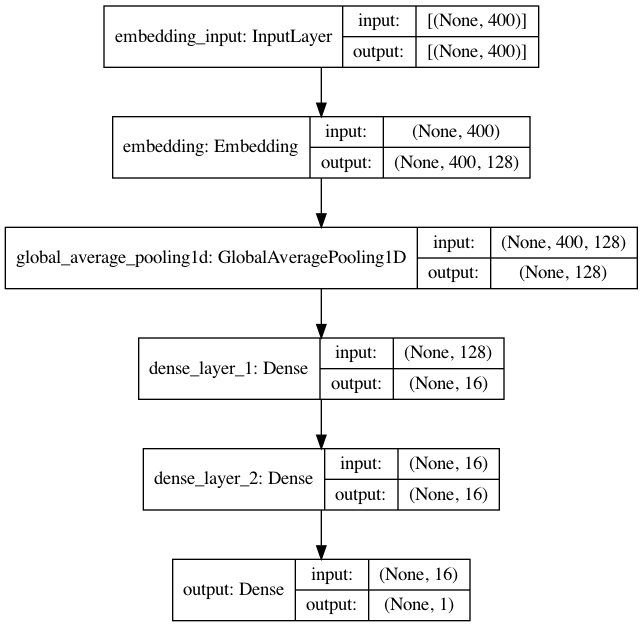

In [30]:
plot_model(model2, show_shapes=True)

In [31]:
history2 = model2.fit(X_train, y_train, 
                    batch_size=BATCH_SIZE, 
                    epochs=EPOCHS, verbose=2,
                    validation_split = VALIDATION_SPLIT)

Epoch 1/25
12/12 - 1s - loss: 0.6929 - accuracy: 0.5028 - val_loss: 0.6918 - val_accuracy: 0.5306
Epoch 2/25
12/12 - 0s - loss: 0.6907 - accuracy: 0.5632 - val_loss: 0.6894 - val_accuracy: 0.5806
Epoch 3/25
12/12 - 0s - loss: 0.6863 - accuracy: 0.6576 - val_loss: 0.6850 - val_accuracy: 0.6583
Epoch 4/25
12/12 - 0s - loss: 0.6787 - accuracy: 0.6868 - val_loss: 0.6786 - val_accuracy: 0.7500
Epoch 5/25
12/12 - 0s - loss: 0.6657 - accuracy: 0.8417 - val_loss: 0.6669 - val_accuracy: 0.6528
Epoch 6/25
12/12 - 0s - loss: 0.6446 - accuracy: 0.8500 - val_loss: 0.6494 - val_accuracy: 0.7278
Epoch 7/25
12/12 - 0s - loss: 0.6116 - accuracy: 0.8910 - val_loss: 0.6242 - val_accuracy: 0.7472
Epoch 8/25
12/12 - 0s - loss: 0.5651 - accuracy: 0.9139 - val_loss: 0.5911 - val_accuracy: 0.7778
Epoch 9/25
12/12 - 0s - loss: 0.5040 - accuracy: 0.9361 - val_loss: 0.5526 - val_accuracy: 0.7861
Epoch 10/25
12/12 - 0s - loss: 0.4337 - accuracy: 0.9500 - val_loss: 0.5110 - val_accuracy: 0.7944
Epoch 11/25
12/12 -

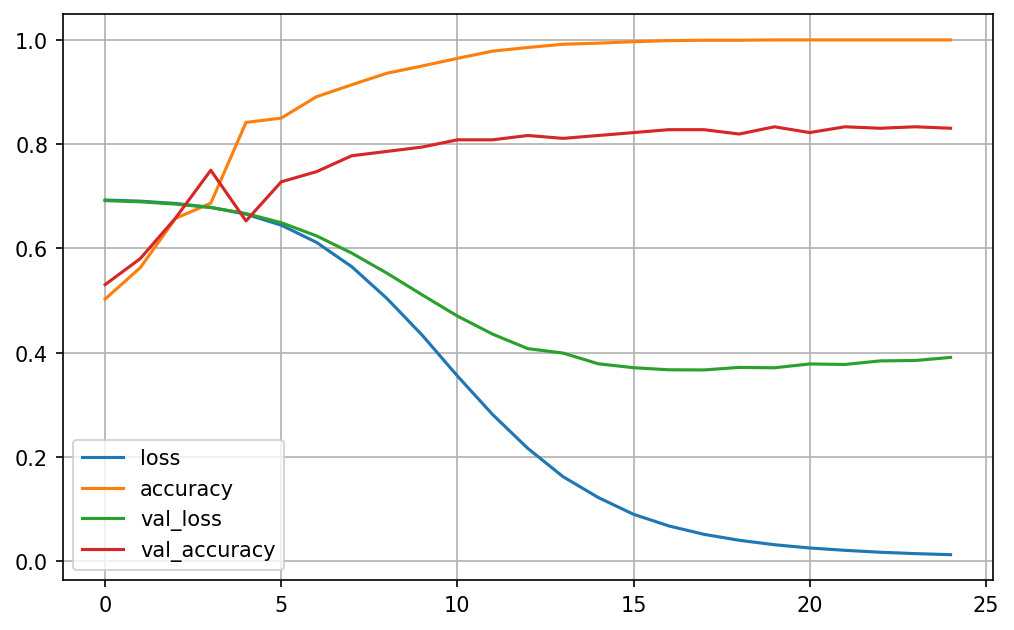

In [32]:
plot2(history2)

In [33]:
model2.evaluate(X_test, y_test, batch_size=128, verbose=2)

2/2 - 0s - loss: 0.3670 - accuracy: 0.8150


[0.3669983744621277, 0.8149999976158142]

## Issues of Word/Character Representations

- Generally speaking, we can train our word embeddings along with the downstream NLP task (e.g., the sentiment classification in our current case).
- Another common method is to train the word embeddings using unsupervised methods on a large amount of data and apply the pre-trained word embeddings to the current downstream NLP task. Typical methods include word2vec (CBOW or skipped-gram, GloVe etc). We will come back to these later.

## Sequence Models

### Model 3

- One Embedding Layer + LSTM + Dense Layer
- Input: the padded text-to-sequences

![](../images/movie-review-classifier-dl/movie-review-classifier-dl.012.jpeg)

In [34]:
EMBEDDING_DIM = 128
model3 = Sequential()
model3.add(Embedding(input_dim=vocab_size, output_dim=EMBEDDING_DIM, input_length=max_len, mask_zero=True))
model3.add(LSTM(16, dropout=0.2, recurrent_dropout=0.5))
model3.add(Dense(1, activation="sigmoid"))

model3.compile(
    loss=keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(lr=0.001),
    metrics=["accuracy"]
)

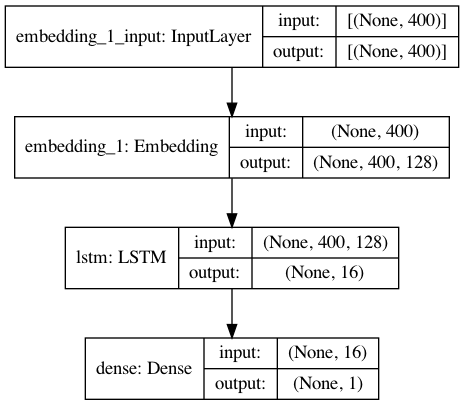

In [35]:
plot_model(model3, show_shapes=True)

In [36]:
history3 = model3.fit(X_train, y_train, 
                    batch_size=BATCH_SIZE, 
                    epochs=EPOCHS, verbose=2,
                   validation_split = VALIDATION_SPLIT)

Epoch 1/25
12/12 - 8s - loss: 0.6923 - accuracy: 0.5028 - val_loss: 0.6884 - val_accuracy: 0.6111
Epoch 2/25
12/12 - 5s - loss: 0.6767 - accuracy: 0.7444 - val_loss: 0.6793 - val_accuracy: 0.6333
Epoch 3/25
12/12 - 4s - loss: 0.6393 - accuracy: 0.8007 - val_loss: 0.6472 - val_accuracy: 0.6556
Epoch 4/25
12/12 - 5s - loss: 0.5204 - accuracy: 0.8569 - val_loss: 0.5364 - val_accuracy: 0.7389
Epoch 5/25
12/12 - 4s - loss: 0.3776 - accuracy: 0.8681 - val_loss: 0.5192 - val_accuracy: 0.7444
Epoch 6/25
12/12 - 4s - loss: 0.3029 - accuracy: 0.9347 - val_loss: 0.5177 - val_accuracy: 0.7583
Epoch 7/25
12/12 - 5s - loss: 0.2416 - accuracy: 0.9590 - val_loss: 0.5909 - val_accuracy: 0.7306
Epoch 8/25
12/12 - 4s - loss: 0.1796 - accuracy: 0.9660 - val_loss: 0.5278 - val_accuracy: 0.7611
Epoch 9/25
12/12 - 5s - loss: 0.1438 - accuracy: 0.9806 - val_loss: 0.6142 - val_accuracy: 0.7444
Epoch 10/25
12/12 - 5s - loss: 0.1189 - accuracy: 0.9847 - val_loss: 0.5316 - val_accuracy: 0.7722
Epoch 11/25
12/12 -

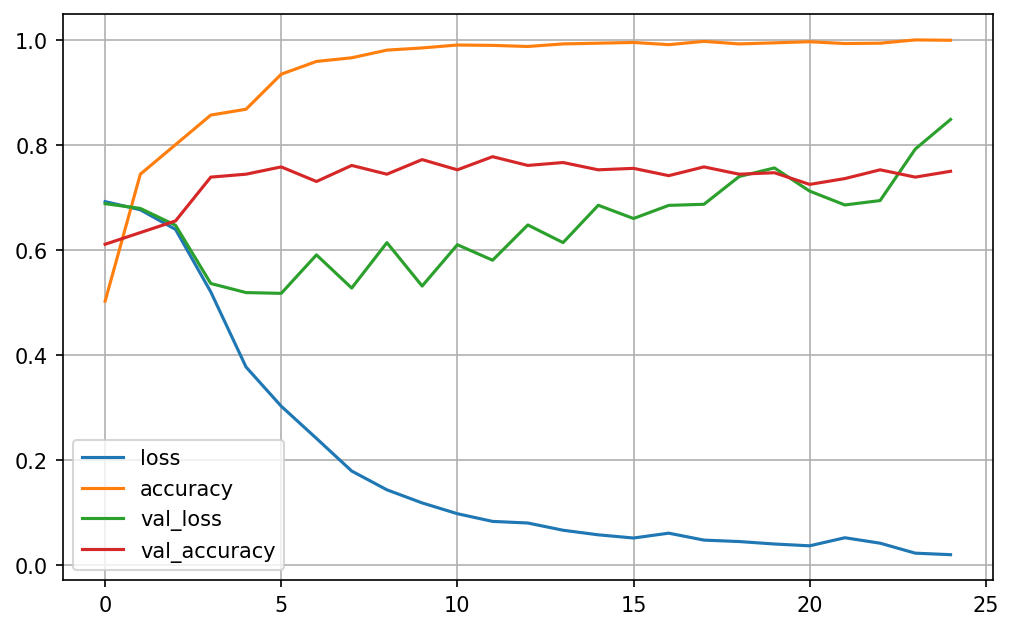

In [37]:
plot2(history3)

In [38]:
model3.evaluate(X_test, y_test, batch_size=128, verbose=2)

2/2 - 0s - loss: 1.0313 - accuracy: 0.7100


[1.031325101852417, 0.7099999785423279]

### Model 4

- One Embedding Layer + Two Stacked LSTM + Dense Layer

![](../images/movie-review-classifier-dl/movie-review-classifier-dl.013.jpeg)

In [39]:
EMBEDDING_DIM = 128
model4 = Sequential()
model4.add(Embedding(input_dim=vocab_size, output_dim=EMBEDDING_DIM, input_length=max_len, mask_zero=True))
model4.add(LSTM(16, return_sequences=True, dropout=0.2, recurrent_dropout=0.5)) #)
model4.add(LSTM(16, dropout=0.2, recurrent_dropout=0.5))
model4.add(Dense(1, activation="sigmoid"))

model4.compile(
    loss=keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(lr=0.001),
    metrics=["accuracy"]
)

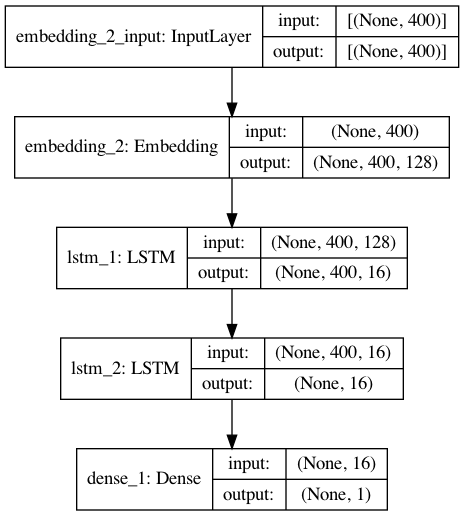

In [40]:
plot_model(model4,show_shapes=True)

In [41]:
history4 = model4.fit(X_train, y_train, 
                    batch_size=BATCH_SIZE, 
                    epochs=EPOCHS, verbose=2,
                   validation_split = 0.2)

Epoch 1/25
12/12 - 14s - loss: 0.6930 - accuracy: 0.4958 - val_loss: 0.6915 - val_accuracy: 0.6250
Epoch 2/25
12/12 - 8s - loss: 0.6882 - accuracy: 0.7417 - val_loss: 0.6882 - val_accuracy: 0.6333
Epoch 3/25
12/12 - 8s - loss: 0.6705 - accuracy: 0.8083 - val_loss: 0.6711 - val_accuracy: 0.6500
Epoch 4/25
12/12 - 8s - loss: 0.5859 - accuracy: 0.8278 - val_loss: 0.6088 - val_accuracy: 0.6583
Epoch 5/25
12/12 - 8s - loss: 0.4036 - accuracy: 0.8569 - val_loss: 0.5967 - val_accuracy: 0.6944
Epoch 6/25
12/12 - 8s - loss: 0.2449 - accuracy: 0.9354 - val_loss: 0.6095 - val_accuracy: 0.7000
Epoch 7/25
12/12 - 8s - loss: 0.1504 - accuracy: 0.9722 - val_loss: 0.6992 - val_accuracy: 0.7083
Epoch 8/25
12/12 - 8s - loss: 0.0992 - accuracy: 0.9882 - val_loss: 0.7233 - val_accuracy: 0.7000
Epoch 9/25
12/12 - 8s - loss: 0.0719 - accuracy: 0.9931 - val_loss: 0.8676 - val_accuracy: 0.6833
Epoch 10/25
12/12 - 8s - loss: 0.0604 - accuracy: 0.9931 - val_loss: 0.8272 - val_accuracy: 0.6972
Epoch 11/25
12/12 

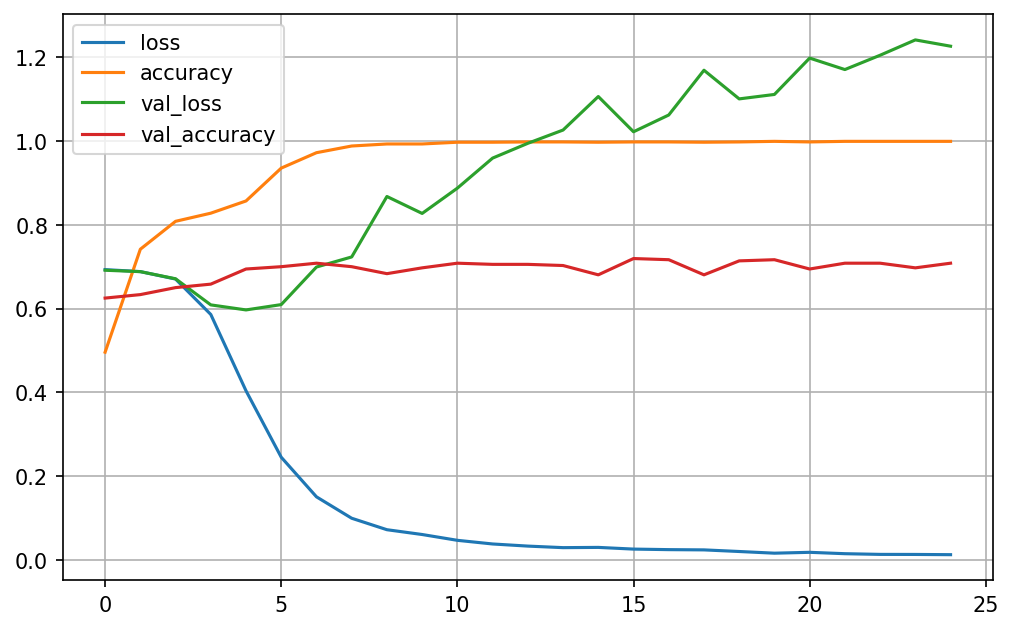

In [42]:
plot2(history4)

In [43]:
model4.evaluate(X_test, y_test, batch_size=BATCH_SIZE, verbose=2)

2/2 - 0s - loss: 1.4019 - accuracy: 0.6850


[1.4019100666046143, 0.6850000023841858]

### Model 5

- Embedding Layer + Bidirectional LSTM + Dense Layer

![](../images/movie-review-classifier-dl/movie-review-classifier-dl.014.jpeg)

In [44]:
EMBEDDING_DIM = 128
model5 = Sequential()
model5.add(Embedding(input_dim=vocab_size, output_dim=EMBEDDING_DIM, input_length=max_len, mask_zero=True))
model5.add(Bidirectional(LSTM(16, dropout=0.2, recurrent_dropout=0.5)))
model5.add(Dense(1, activation="sigmoid"))

model5.compile(
    loss=keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(lr=0.001),
    metrics=["accuracy"]
)

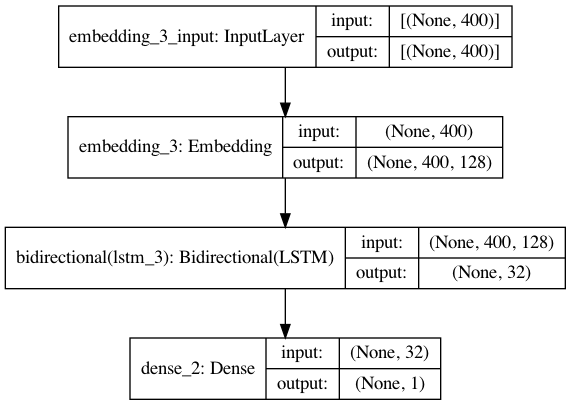

In [45]:
plot_model(model5, show_shapes=True)

In [46]:
history5 = model5.fit(X_train, y_train, 
                    batch_size=BATCH_SIZE, 
                    epochs=EPOCHS, verbose=2,
                   validation_split = 0.2)

Epoch 1/25
12/12 - 14s - loss: 0.6926 - accuracy: 0.5368 - val_loss: 0.6900 - val_accuracy: 0.5639
Epoch 2/25
12/12 - 7s - loss: 0.6777 - accuracy: 0.8132 - val_loss: 0.6837 - val_accuracy: 0.6472
Epoch 3/25
12/12 - 7s - loss: 0.6493 - accuracy: 0.8819 - val_loss: 0.6669 - val_accuracy: 0.6972
Epoch 4/25
12/12 - 7s - loss: 0.5722 - accuracy: 0.9028 - val_loss: 0.5875 - val_accuracy: 0.7333
Epoch 5/25
12/12 - 7s - loss: 0.4084 - accuracy: 0.8722 - val_loss: 0.5424 - val_accuracy: 0.7472
Epoch 6/25
12/12 - 7s - loss: 0.3439 - accuracy: 0.9236 - val_loss: 0.5452 - val_accuracy: 0.7500
Epoch 7/25
12/12 - 7s - loss: 0.2221 - accuracy: 0.9688 - val_loss: 0.5330 - val_accuracy: 0.7139
Epoch 8/25
12/12 - 7s - loss: 0.1477 - accuracy: 0.9868 - val_loss: 0.5569 - val_accuracy: 0.7111
Epoch 9/25
12/12 - 7s - loss: 0.1121 - accuracy: 0.9889 - val_loss: 0.6033 - val_accuracy: 0.7056
Epoch 10/25
12/12 - 7s - loss: 0.0820 - accuracy: 0.9958 - val_loss: 0.6185 - val_accuracy: 0.6944
Epoch 11/25
12/12 

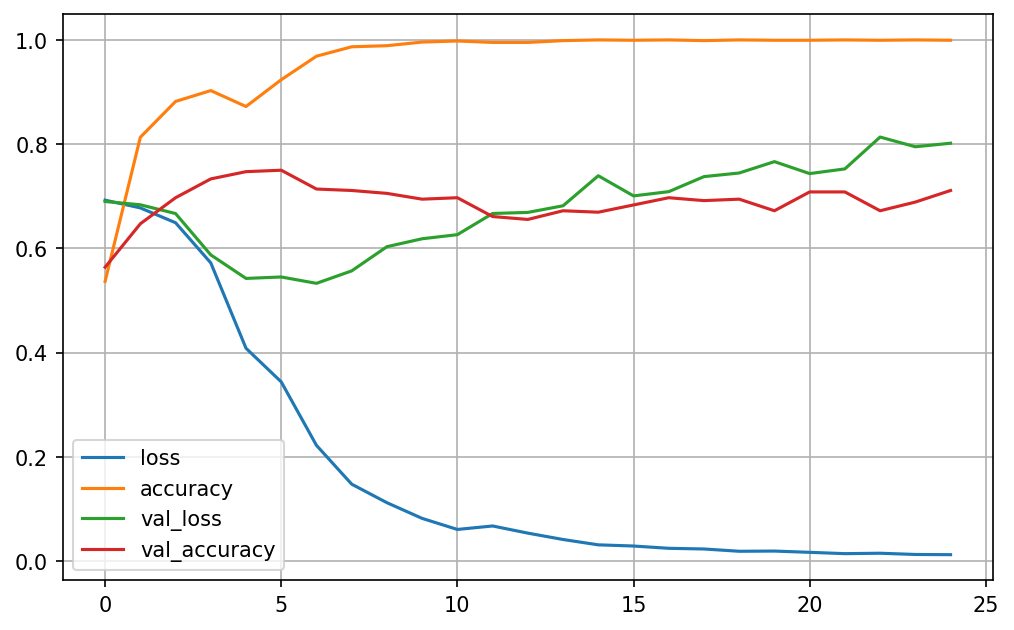

In [47]:
plot2(history5)

In [48]:
model5.evaluate(X_test, y_test, batch_size=BATCH_SIZE, verbose=2)

2/2 - 0s - loss: 0.9430 - accuracy: 0.6650


[0.9429590106010437, 0.6650000214576721]

## Even More Complex Sequence Models

### Model 6

- One Embedding Layer + LSTM [hidden state of last time step + cell state of last time step] + Dense Layer

![](../images/movie-review-classifier-dl/movie-review-classifier-dl.015.jpeg)

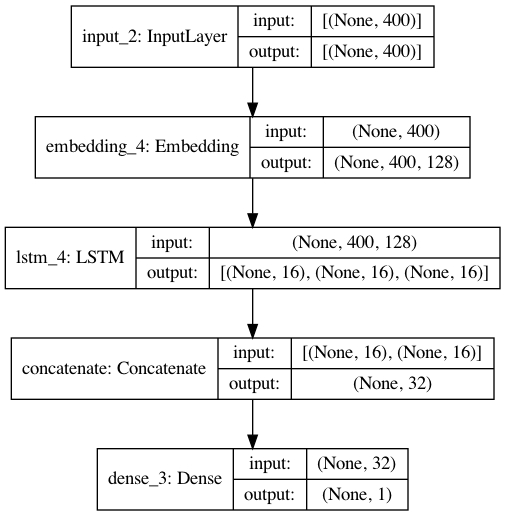

In [49]:
EMBEDDING_DIM = 128

## Functional API
inputs = keras.Input(shape=(max_len,))
x=layers.Embedding(input_dim=vocab_size, output_dim=EMBEDDING_DIM, input_length=max_len, mask_zero=True)(inputs)
_,x_last_h, x_c = layers.LSTM(16, dropout=0.2, 
                               recurrent_dropout=0.5, 
                               return_sequences=False, return_state=True)(x)
## LSTM Parameters:
#     `return_seqeunces=True`: return the hidden states for each time step
#     `return_state=True`: return the cell state of the last time step
#     When both are set True, the return values of LSTM are:
#     (1) the hidden states of all time steps (when `return_sequences=True`) or the hidden state of the last time step
#     (2) the hidden state of the last time step
#     (3) the cell state of the last time step

x = layers.Concatenate(axis=1)([x_last_h, x_c])
outputs=layers.Dense(1, activation='sigmoid')(x)
model6 = keras.Model(inputs=inputs, outputs=outputs)

plot_model(model6, show_shapes=True)

In [50]:
model6.compile(
    loss=keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(lr=0.001),
    metrics=["accuracy"]
)
history6 = model6.fit(X_train, y_train, 
                    batch_size=BATCH_SIZE, 
                    epochs=EPOCHS, verbose=2,
                   validation_split = VALIDATION_SPLIT)

Epoch 1/25
12/12 - 8s - loss: 0.6930 - accuracy: 0.5125 - val_loss: 0.6880 - val_accuracy: 0.6167
Epoch 2/25
12/12 - 4s - loss: 0.6766 - accuracy: 0.7208 - val_loss: 0.6809 - val_accuracy: 0.6361
Epoch 3/25
12/12 - 4s - loss: 0.6464 - accuracy: 0.8069 - val_loss: 0.6623 - val_accuracy: 0.6444
Epoch 4/25
12/12 - 4s - loss: 0.5725 - accuracy: 0.8514 - val_loss: 0.6231 - val_accuracy: 0.6389
Epoch 5/25
12/12 - 4s - loss: 0.4075 - accuracy: 0.8806 - val_loss: 0.5528 - val_accuracy: 0.7111
Epoch 6/25
12/12 - 4s - loss: 0.2130 - accuracy: 0.9285 - val_loss: 0.6316 - val_accuracy: 0.7389
Epoch 7/25
12/12 - 4s - loss: 0.1140 - accuracy: 0.9715 - val_loss: 0.8445 - val_accuracy: 0.7194
Epoch 8/25
12/12 - 5s - loss: 0.0738 - accuracy: 0.9792 - val_loss: 0.6538 - val_accuracy: 0.7306
Epoch 9/25
12/12 - 4s - loss: 0.0418 - accuracy: 0.9931 - val_loss: 0.7639 - val_accuracy: 0.7472
Epoch 10/25
12/12 - 4s - loss: 0.0236 - accuracy: 0.9958 - val_loss: 0.8178 - val_accuracy: 0.7472
Epoch 11/25
12/12 -

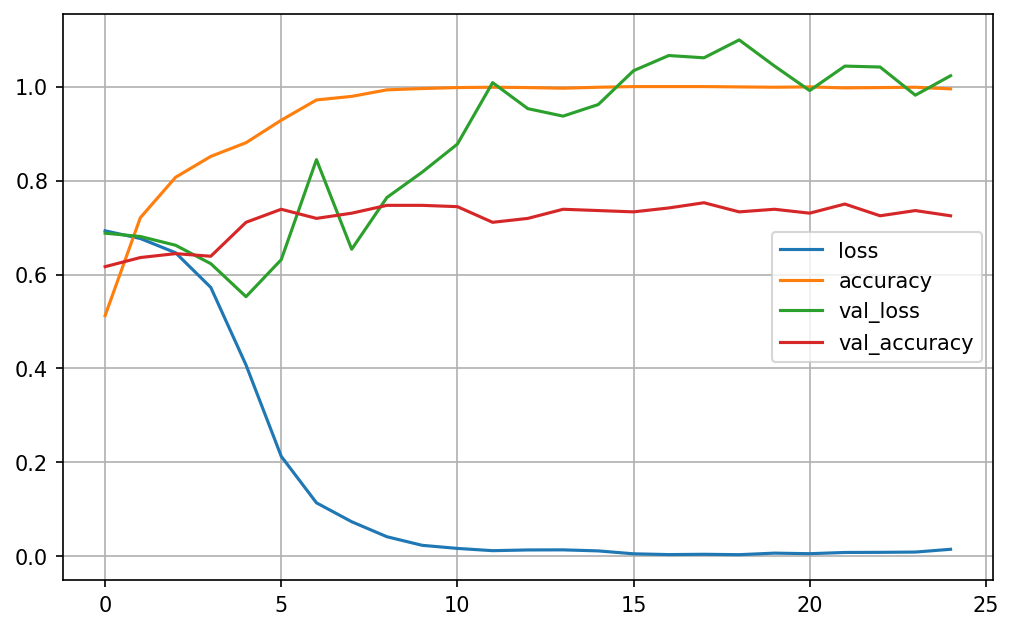

In [51]:
plot2(history6)

In [52]:
model6.evaluate(X_test, y_test, batch_size=128, verbose=2)

2/2 - 0s - loss: 1.2482 - accuracy: 0.6800


[1.2481950521469116, 0.6800000071525574]

### Model 7

- All of the previous RNN-based models only utilize the output of the last time step from the RNN as the input of the subsequent layers.
- We can also make all the hidden outputs at all time steps from the RNN available to the subsequent layers.
- This is the idea of **Attention**.
- Here we add one `AttentionLayer`, which gives us a weighted version of all the hidden states from the RNN. These outputs from AttentionLayer indicate how relevant each hidden state is to computation of the subsequent layer.
    - Use the hidden state h as the **query** and the **key** is all the hidden states from LSTM.
    - The Attention layer shows how the last state (query) is connected to all the previous hidden states (key).
    - The Attention layer will return a weighted version of all the hidden states.

![](../images/movie-review-classifier-dl/movie-review-classifier-dl.016.jpeg)

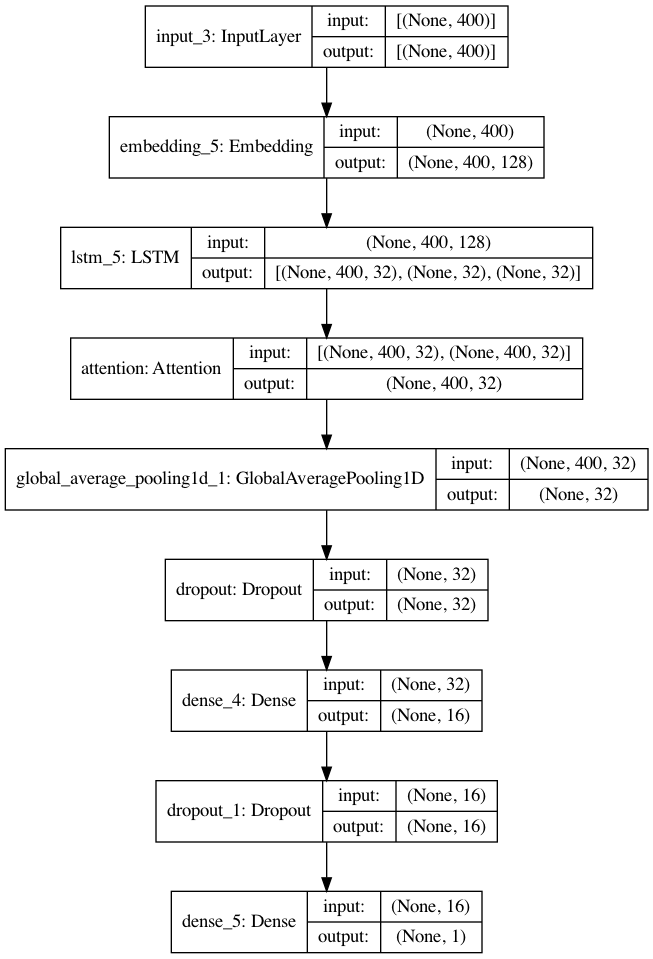

In [53]:
EMBEDDING_DIM = 128

inputs = keras.Input(shape=(max_len,))
x=layers.Embedding(input_dim=vocab_size, output_dim=EMBEDDING_DIM, input_length=max_len,mask_zero=True)(inputs)
x_all_hs, x_last_h, x_last_c = layers.LSTM(32, dropout=0.2, 
                               recurrent_dropout=0.5, 
                               return_sequences=True, return_state=True)(x)
## LSTM Parameters:
#     `return_seqeunces=True`: return the hidden states for each time step
#     `return_state=True`: return the cell state of the last time step
#     When both are set True, the return values of LSTM are:
#     (1) the hidden states of all time steps (when `return_sequences=True`) or the hidden state of the last time step
#     (2) the hidden state of the last time step
#     (3) the cell state of the last time step

## Self Attention
atten_out = layers.Attention()([x_all_hs, x_all_hs]) # query and key 
#x_all_hs_weighted = layers.GlobalAveragePooling1D()(atten_out)
#x_last_h_plus_x_all_hs_weighted = layers.Concatenate(axis=1)([x_last_h, x_all_hs_weighted])
atten_out_flat = layers.GlobalAveragePooling1D()(atten_out)
x = layers.Dropout(0.1)(atten_out_flat)
x = layers.Dense(16, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs=layers.Dense(1, activation='sigmoid')(x)
model7 = keras.Model(inputs=inputs, outputs=outputs)

plot_model(model7, show_shapes=True)

In [54]:
model7.compile(
    loss=keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(lr=0.001),
    metrics=["accuracy"]
)
history7 = model7.fit(X_train, y_train, 
                    batch_size=BATCH_SIZE, 
                    epochs=EPOCHS, verbose=2,
                   validation_split = VALIDATION_SPLIT)

Epoch 1/25
12/12 - 12s - loss: 0.6925 - accuracy: 0.5424 - val_loss: 0.6909 - val_accuracy: 0.6778
Epoch 2/25
12/12 - 8s - loss: 0.6849 - accuracy: 0.7486 - val_loss: 0.6764 - val_accuracy: 0.6667
Epoch 3/25
12/12 - 8s - loss: 0.6214 - accuracy: 0.7986 - val_loss: 0.6131 - val_accuracy: 0.6722
Epoch 4/25
12/12 - 9s - loss: 0.4664 - accuracy: 0.8250 - val_loss: 0.5471 - val_accuracy: 0.7333
Epoch 5/25
12/12 - 9s - loss: 0.3585 - accuracy: 0.9264 - val_loss: 0.6224 - val_accuracy: 0.7222
Epoch 6/25
12/12 - 9s - loss: 0.2218 - accuracy: 0.9396 - val_loss: 0.5750 - val_accuracy: 0.7528
Epoch 7/25
12/12 - 9s - loss: 0.1333 - accuracy: 0.9771 - val_loss: 0.8602 - val_accuracy: 0.7222
Epoch 8/25
12/12 - 9s - loss: 0.1592 - accuracy: 0.9542 - val_loss: 0.4979 - val_accuracy: 0.7861
Epoch 9/25
12/12 - 8s - loss: 0.1137 - accuracy: 0.9812 - val_loss: 0.8562 - val_accuracy: 0.7278
Epoch 10/25
12/12 - 8s - loss: 0.0494 - accuracy: 0.9889 - val_loss: 1.0203 - val_accuracy: 0.7361
Epoch 11/25
12/12 

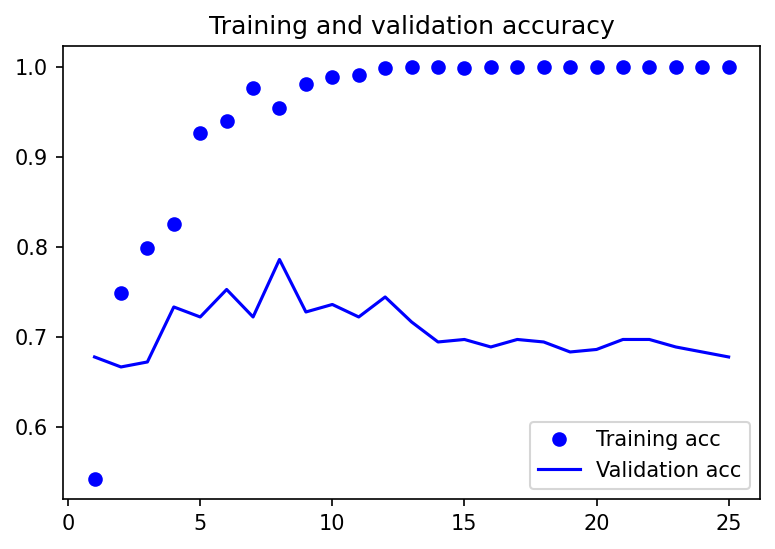

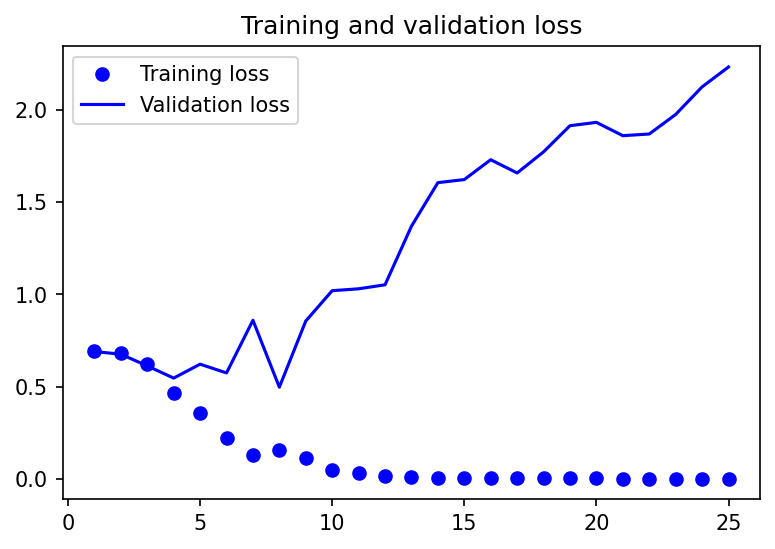

In [55]:
plot(history7)

In [56]:
model7.evaluate(X_test, y_test, batch_size=BATCH_SIZE, verbose=2)

2/2 - 0s - loss: 2.1696 - accuracy: 0.6800


[2.1695716381073, 0.6800000071525574]

## Explanation

In [57]:
from lime.lime_text import LimeTextExplainer

explainer = LimeTextExplainer(class_names=['negative','positive'], char_level=False)

In [58]:
## Select the best model so far
best_model = model2

## Pipeline for LIME
def model_predict_pipeline(text):
    _seq = tokenizer.texts_to_sequences(text)
    _seq_pad = keras.preprocessing.sequence.pad_sequences(_seq, maxlen=max_len)
    return np.array([[float(1-x), float(x)] for x in best_model.predict(np.array(_seq_pad))])


In [59]:
text_id = 3
model_predict_pipeline([X_test_texts[text_id]])

array([[0.99219871, 0.00780132]])

In [60]:
text_id=3
exp = explainer.explain_instance(
X_test_texts[text_id], model_predict_pipeline, num_features=20, top_labels=1)
exp.show_in_notebook(text=True)

In [61]:
exp.show_in_notebook(text=True)

## Check Embeddings

- Let's check the word embeddings learned along with the Sentiment Classifier.

In [62]:
word_vectors = best_model.layers[0].get_weights()[0]
word_vectors.shape

(10001, 128)

In [63]:
token_labels = [word for (ind, word) in tokenizer.index_word.items() if ind < word_vectors.shape[0]]
token_labels.insert(0,"PAD")
token_labels[:10]

['PAD', 'the', 'a', 'and', 'of', 'to', "'", 'is', 'in', 's']

In [64]:
len(token_labels)

10001

- Check embeddings of words that are not on the stopword list and whose word length >= 5 (characters)

In [65]:
from sklearn.manifold import TSNE
stopword_list = nltk.corpus.stopwords.words('english')

In [66]:
out_index = [i for i, w in enumerate(token_labels) if len(w)>=5 and w not in stopword_list]
len(out_index)

8210

In [67]:
out_index[:10]

[28, 69, 70, 73, 82, 83, 93, 96, 99, 101]

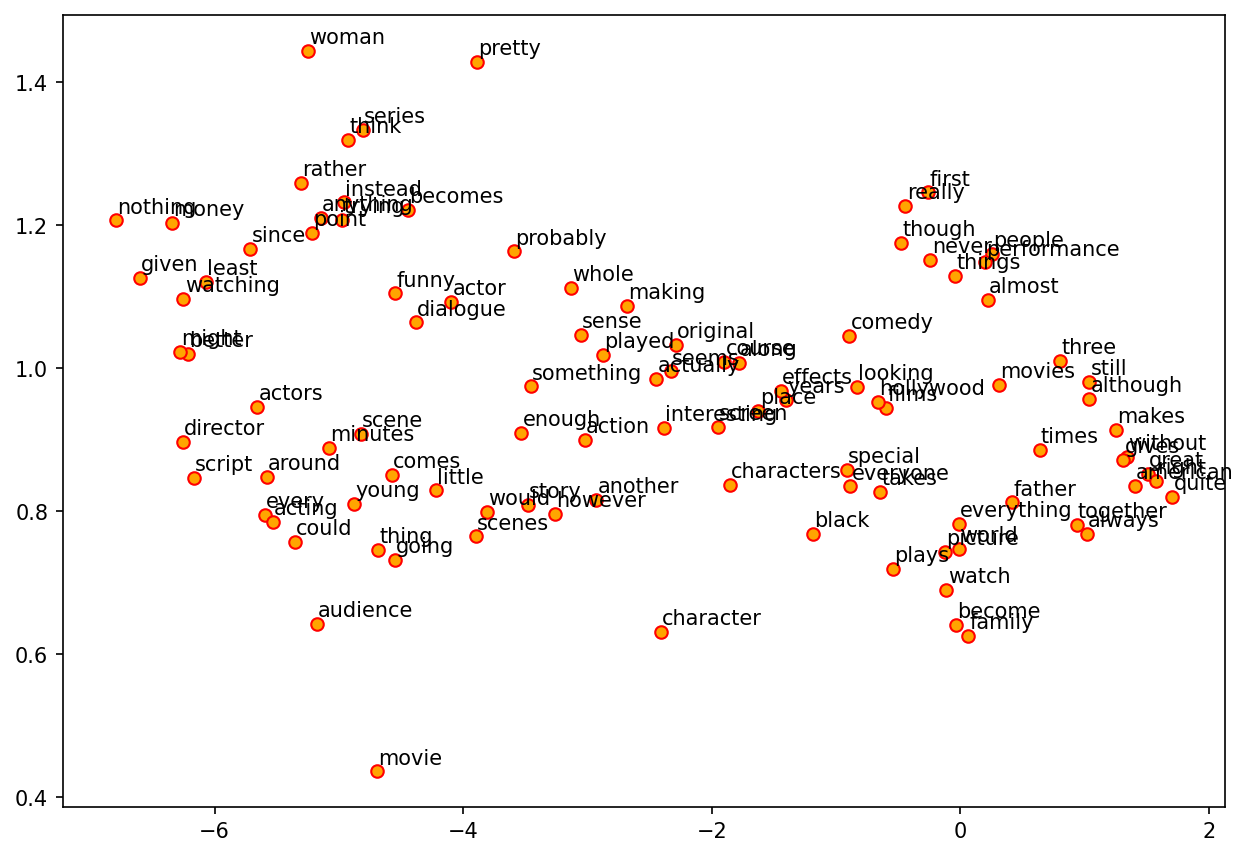

In [68]:
tsne = TSNE(n_components=2, random_state=0, n_iter=5000, perplexity=50)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(word_vectors[out_index[:100],])
labels = list(np.array(token_labels)[out_index[:100]])

len(labels)

plt.figure(figsize=(10, 7), dpi=150)
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+0.01, y+0.01), xytext=(0, 0), textcoords='offset points')